BE - AML Laurent THONGKHAM

# Sequence to Sequence Learning with Neural Networks


## Problematic

Deep Neural Networks are very powerful tools for problem solving and parameters optimization. However, the working assumption is that both the input and the target can be embodied by vectors of fixed dimensionality. Many problems do not submit to that hypothesis. Speech recognition or machine translation are sequential problems where the length of the inputs can not be asserted beforehand.

The paper *Sequence to Sequence Learning
with Neural Networks* aims at designing a method to learn to map sequences to sequences.


To do so, the main idea is to use a **Long Short-Term Memory(LSTM) architecture**. One is used to read the input sequence and turn it into a vector with a fixed dimensionality while a second one will extract the output sequence from the vector. The goal is to estimate the conditional probability p(y1, ..., yT'|x1, ..., xT) with (x1, ..., xT) as the input and (y1, ..., yT') as the output sequences.

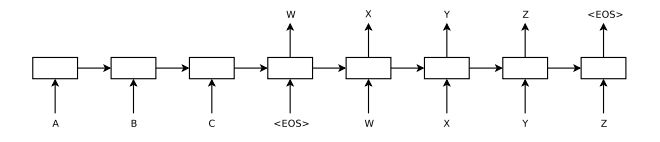

A sequence "A", "B", "C", "EOS" (end-of-sentence token) is taken by the model to compute the probability of "W", "X", "Y", "Z", "EOS". The EOS token enables the model to oversee sequences of different lengths.

In this notebook, we will apply the proposed method on a machine translation example and lean over the findings of the paper.

The **3 important findings** of the paper are:


*   the use of two different LSTMs for the input and the output sequences
*   the efficiency of deep LSTMs over shallow ones
*   the order reversal of the elements of the input sequence

Concerning the deep LSTMs, although the authors of the paper found that deep LSTMs outperformed shallow LSTMs and decided to use an LSTM with four layers. We will only use two layers in this notebook in order to save some training time.



## Import libraries and data

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import string
import math

In [2]:
# Parameters

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 5000  # Number of samples to train on.

In [3]:
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip

['Archive:  fra-eng.zip',
 '  inflating: _about.txt              ',
 '  inflating: fra.txt                 ']

In [4]:
# Path to the data txt file.
data_path = "fra.txt"

with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

lines[0:10]

['Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)',
 'Hi.\tSalut !\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)',
 'Hi.\tSalut.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)',
 'Run!\tCours\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)',
 'Run!\tCourez\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)',
 'Who?\tQui ?\tCC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #4366796 (gillux)',
 'Wow!\tÇa alors\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #374631 (zmoo)',
 'Fire!\tAu feu !\tCC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #4627939 (sacredceltic)',
 "Help!\tÀ l'aide\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #128430 (sysko)",
 'Jump.\tSaute.\tCC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishi

# Data processing

The data we will use is for english-to-french translation. As you can see, we need to clean it a bit. We will organize of dictionary of the vocabulary selected for training.

In [5]:
# Vectorize the data.
input_texts = []
target_texts = []
input_words = set()
target_words = set()

# This function cleans and extracts the input and target words from text_lines
def extract_words(text_lines, reverse_source=True):
  for line in text_lines:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character for the targets
    # and "\n" as "end sequence" character.
    target_text = "\t " + target_text + " \n"

    input_text = input_text.translate(str.maketrans('', '', string.punctuation))
    target_text = target_text.translate(str.maketrans('', '', string.punctuation))
    input_text_words = input_text.split(" ")
    target_text_words = target_text.split(" ")

    if reverse_source:
      input_text = ' '.join(reversed(input_text_words))  
    
    input_texts.append(input_text)
    target_texts.append(target_text)

    for word in input_text_words:
        if word not in input_words:
            input_words.add(word)
    for word in target_text_words:
        if word not in target_words:
            target_words.add(word)

Note that in the extract_words function, we decide to **reverse the order of words in the input sentence**. This is the most important discovery of the paper as it extremely improves performances. The authors suspect that this reversal allows the model to learn short termn dependencies more easily. Usually, when the source sentence and the target sentence are concatenated together, every word is far from its translated peer. With the input reversed, even though the average distance between the pairs of words remains the same. The distance between the first words of the sentences is shortened.

Contrary to what was expected, this method improves performance for short sentences but also for long sentences. Which leads to believe that reversed input sentences enables an overall better use of the LSTM's memory.

In [6]:
# Sort the sentences by length
lines.sort(key = len)
short_marker = 1
mid_marker = 120000
long_marker = 179000
print(len(lines))
print()
print("Short sentences:")
print(lines[50])
print()
print("Mid-long sentences:")
print(lines[130000])
print()
print("Long sentences:")
print(lines[179505])

179905

Short sentences:
Help Tom.	Aidez Tom.	CC-BY 2.0 (France) Attribution: tatoeba.org #2203858 (CK) & #6465578 (Aiji)

Mid-long sentences:
You don't know Tom as well as I do.	Tu ne connais pas Tom aussi bien que moi.	CC-BY 2.0 (France) Attribution: tatoeba.org #6818805 (CK) & #6818869 (Rockaround)

Long sentences:
I can't believe that you aren't at least willing to consider the possibility of other alternatives.	Je n'arrive pas à croire que vous ne soyez pas au moins disposé à envisager d'autres possibilités.	CC-BY 2.0 (France) Attribution: tatoeba.org #1950847 (CK) & #1951063 (sacredceltic)


Machine translation uses very large datasets and thus costs a heavy load of computational power. The paper trained its model with a dataset of 12M sentences including 348M French words and 304M English words, and took about 10 days. Since we do not have that processing power and time, we will have to cut down on the samples of sentences.

The distribution of length of the sentences should be decided accordingly to the study case. Although training long sentences is very difficult in the context of this notebook. Consider reducing the number of samples if you find yourself short of RAM.



In [7]:
# The distribution of length of sentences
# In this case, we have a 90%/10% short/mid-long sentences ratio

extract_words(lines[short_marker: short_marker + math.floor(num_samples*0.9)], False)
extract_words(lines[mid_marker: mid_marker + math.floor(num_samples*0.1)], False)

input_words = sorted(list(input_words))
target_words = sorted(list(target_words))
num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 5000
Number of unique input tokens: 2164
Number of unique output tokens: 3632
Max sequence length for inputs: 32
Max sequence length for outputs: 53


In [8]:
input_texts[-15:]

['him around gathered soon crowd A',
 'have you do money much how About',
 'solution no theres sure you Are',
 'country mountainous a is Armenia',
 'something do to tried I least At',
 'included are lunch and Breakfast',
 'way another in phrased be it Can',
 'suitcase my pack me help you Can',
 'her interest doesnt food Canned',
 'oclock six exactly at here Come',
 'second a for this hold you Could',
 'yesterday yourself enjoy you Did',
 'him to letter a write you Didnt',
 'patio the on table a have you Do',
 'box this open to how know you Do']

In [9]:
target_texts[-15:]

['\t Bientôt une foule se rassembla autour de lui \n',
 '\t Combien avezvous dargent\u202fenviron\u202f \n',
 '\t Estu sûr quil ny a pas de solution\xa0 \n',
 '\t LArménie est un pays montagneux \n',
 '\t Au moins jai essayé de faire quelque chose \n',
 '\t Le petitdéjeuner et le déjeuner sont inclus \n',
 '\t Estce quon peut formuler ça dune autre manière\u202f \n',
 '\t Peuxtu maider à faire ma valise  \n',
 '\t La nourriture en conserve ne lintéresse pas \n',
 '\t Venez ici à dixhuit heures précises \n',
 '\t Estce que tu pourrais tenir ça une seconde\xa0 \n',
 '\t Estce que vous vous êtes bien amusé hier  \n',
 '\t Ne lui avezvous pas écrit une lettre\u202f \n',
 '\t Disposestu dune table sur le patio  \n',
 '\t Savezvous comment ouvrir cette boîte  \n']

We tokenize the words.

In [10]:
input_token_index = dict([(word, i) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i) for i, word in enumerate(target_words)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)

decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

In [11]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    input_text_words = input_text.split(" ")
    target_text_words = target_text.split(" ")
    for t, word in enumerate(input_text_words):
        encoder_input_data[i, t, input_token_index[word]] = 1.0
    for t, word in enumerate(target_text_words):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[word]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start word.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index["\n"]] = 1.0
    decoder_target_data[i, t:, target_token_index["\n"]] = 1.0

# Model

Here, we build the model with 2 layers of LSTM.

In [12]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs) 

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up the decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [13]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")

Epoch 1/100
63/63 [==============================] - 17s 126ms/step - loss: 2.1164 - accuracy: 0.8789 - val_loss: 0.8551 - val_accuracy: 0.9075
Epoch 2/100
63/63 [==============================] - 7s 107ms/step - loss: 0.3368 - accuracy: 0.9516 - val_loss: 0.9630 - val_accuracy: 0.9074
Epoch 3/100
63/63 [==============================] - 7s 108ms/step - loss: 0.3229 - accuracy: 0.9519 - val_loss: 0.8695 - val_accuracy: 0.9093
Epoch 4/100
63/63 [==============================] - 7s 106ms/step - loss: 0.3142 - accuracy: 0.9522 - val_loss: 0.9056 - val_accuracy: 0.9091
Epoch 5/100
63/63 [==============================] - 7s 105ms/step - loss: 0.3010 - accuracy: 0.9529 - val_loss: 0.9186 - val_accuracy: 0.9094
Epoch 6/100
63/63 [==============================] - 7s 109ms/step - loss: 0.2924 - accuracy: 0.9535 - val_loss: 0.9280 - val_accuracy: 0.9091
Epoch 7/100
63/63 [==============================] - 7s 108ms/step - loss: 0.2859 - accuracy: 0.9532 - val_loss: 0.9497 - val_accuracy: 0.909

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


In [14]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0] 
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_word_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_word_index = dict((i, word) for word, i in target_token_index.items())

# Predictions

Now that the model is trained, we can observe the inferences it can produce to see how the training went.

In [15]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_word_index[sampled_token_index]
        decoded_sentence += " "+sampled_char

        # Stop condition: either hit max length or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [36]:
# We take one sequence from the training set to try decoding
sentence_marker = 4500

def display_predictions(number_predictions, index):
  for i in range(number_predictions):
    seq_index = i + index
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    
    input_sentence = input_texts[seq_index].split(' ')
    input_sentence = ' '.join(reversed(input_sentence))

    print("-")
    print("Input sentence:", input_sentence)
    print("Decoded sentence:", decoded_sentence)

display_predictions(10,10)
display_predictions(10,4000)

-
Input sentence: No way
Decoded sentence:  Cest pas possible  

-
Input sentence: I try
Decoded sentence:  Jessaye 

-
Input sentence: Beat it
Decoded sentence:  Dégage  

-
Input sentence: Here it is
Decoded sentence:  Le voilà 

-
Input sentence: Go on
Decoded sentence:  Vasy  

-
Input sentence: Thanks
Decoded sentence:  Merci  

-
Input sentence: Go away
Decoded sentence:  Pars  

-
Input sentence: Go ahead
Decoded sentence:  Passe devant  

-
Input sentence: Stop
Decoded sentence:  Arrêtez ça  

-
Input sentence: Go on
Decoded sentence:  Vasy  

-
Input sentence: Is this your pen
Decoded sentence:  Estce à vous  

-
Input sentence: It happened here
Decoded sentence:  Cest samedi 

-
Input sentence: It was effective
Decoded sentence:  Ce fut efficace 

-
Input sentence: It was excessive
Decoded sentence:  Cétait bon 

-
Input sentence: Its a sunflower
Decoded sentence:  Cest une chanson 

-
Input sentence: Mail this letter
Decoded sentence:  Prenez tout  

-
Input sentence: May I 

Unsurprisingly, the model seems to provide good translations for short sentences but poor ones for longer sentences.

# Bleu scores

In regards to other translation studies, we will use the BLEU score to measure the performance of our model.

BLEU compares the ground truth with prediction made by either comparing words individually between the ground truth and the inference or by pairing up (up to 4 words) together to include dependencies between words. By default, the score will consider groups of 4 words.

In [31]:
from nltk.translate.bleu_score import corpus_bleu

references = []
candidates = []

for seq_index in range(len(encoder_input_data)):
  input_seq = encoder_input_data[seq_index : seq_index + 1]
  decoded_sentence = decode_sequence(input_seq).split(" ")[1:-1]

  references.append([target_texts[seq_index].split(" ")[1:-1]])
  candidates.append(decoded_sentence)

#print(references)
#print(candidates)

score = corpus_bleu(references, candidates)
print(score)

0.2691350240858102


The resulting score is quite poor. But we can improve it.

**Exercise:**

Try improving the BLEU score by reversing the input sentence (with the extract_words function). You can also try different distribution of length sentences for training to observe the effectiveness of the model on short or long sentences.

With more time, the model can also be trained with 4 layers of LSTM.

# Sources

Sequence to Sequence Learning with Neural Networks:

https://proceedings.neurips.cc/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf

Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation:

https://arxiv.org/pdf/1406.1078.pdf